In [5]:
from neo4j import GraphDatabase
import pandas as pd
from openai import OpenAI
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import networkx as nx
import mysql.connector
import json
from collections import Counter
import os
import re
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
# DB接続処理
# Neo4jに接続
uri = "bolt://localhost:7687"
user = "neo4j"
password = "abcd7890"

# ドライバを作成
driver = GraphDatabase.driver(uri, auth=(user, password))

'tomato','basil','cheese_mozzarella_low_moisture_part_skim','olive_oil'
         aroma_id  food_count  total_ratio
0           fatty           2     0.569537
1            mild           3     0.334838
2           faint           3     0.329321
3           yeast           2     0.277696
4           baked           2     0.277696
5           bread           2     0.277696
6   slightly_waxy           2     0.238118
7          bitter           3     0.166366
8           sweet           1     0.058056
9         vanilla           1     0.029518
10         herbal           1     0.029518
11       licorice           1     0.029518
12          anise           1     0.029518
13     sassafrass           1     0.029518
14          minty           1     0.029518
15         fennel           1     0.029518
16        alcohol           1     0.029518
17          green           1     0.029518
18          spice           1     0.029518
19          lemon           1     0.028538
20         floral        

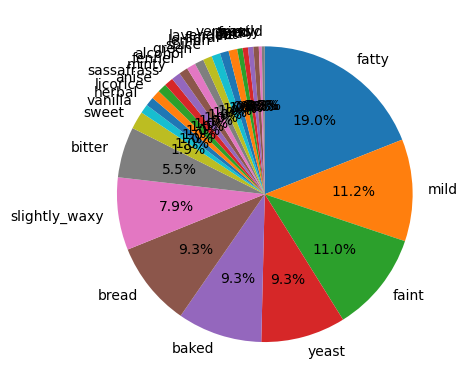

'oyster_raw','kiwi','cucumber'
         aroma_id  food_count  total_ratio
0          grassy           1     0.499225
1       very_mild           1     0.499225
2           fatty           2     0.367313
3           faint           2     0.309084
4          bitter           3     0.266315
5            mild           2     0.185727
6           baked           2     0.160693
7           yeast           1     0.156087
8           bread           1     0.156087
9   slightly_waxy           2     0.111108
10           waxy           2     0.073942
11           lard           1     0.067309
12          fried           1     0.067309
13            fat           1     0.067309
14        coconut           1     0.006634
15          soapy           1     0.006634


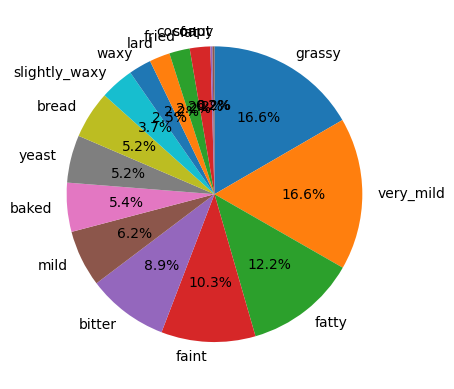

'potato','onion','ham_minced','rye_bread','cheese','mayonnaise'
         aroma_id  food_count  total_ratio
0           fatty           4     0.737521
1          bitter           4     0.727485
2           faint           4     0.577747
3            mild           4     0.501663
4           baked           3     0.270103
5           bread           3     0.270103
6           yeast           3     0.270103
7   slightly_waxy           4     0.237610
8        phenolic           1     0.125738
9        balsamic           1     0.125738
10      very_mild           2     0.054184
11         grassy           2     0.054184
12          fried           1     0.014034
13          soapy           2     0.011263
14        coconut           2     0.011263
15           waxy           2     0.011263


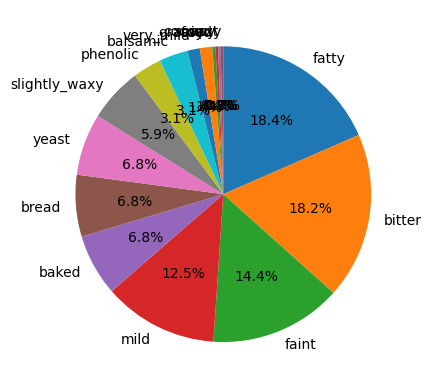

In [7]:
targets=[
    ["tomato", "basil", "mozzarella cheese", "olive oil"],
    ["oyster", "kiwi", "cucumber"],
    ["potato", "onion", "ham", "bread", "cheese", "mayonnaise"],
]

def find_food(tx, search_term):
    find_food_query = """
    CALL db.index.fulltext.queryNodes("food_sub_index_text_search", $search_term)
    YIELD node, score
    ORDER BY score DESC, size(node.name)
    LIMIT 1
    RETURN node.id as node_id, node.name as node_name, score    
    """
    return tx.run(find_food_query, search_term=search_term).data()

def find_aromas(tx, ids):
    find_aromas_query = f"""
    MATCH (f:FoodSubType)-[r:SCENTED]->(a:Aroma)
    WHERE f.id IN [{ids}]
    WITH a.id AS aroma_id, COUNT(f) AS food_count, SUM(r.ratio) AS total_ratio
    RETURN aroma_id, food_count, total_ratio
    ORDER BY total_ratio DESC;
    """
    print(ids)
    return tx.run(find_aromas_query).data()
    
with driver.session() as session:
    for dish in targets:
        node_ids = []
        for target in dish:
            result1 = session.execute_read(find_food, target)  
            for record in result1:
                node_ids.append("'"+ record["node_id"] + "'")
    
        result2 = session.execute_read(find_aromas, ",".join(node_ids))
        pd_result = pd.DataFrame(result2)
        print(pd_result)
        
        plt.pie(
            pd_result['total_ratio'], 
            labels=pd_result['aroma_id'], 
            autopct='%1.1f%%',  # 割合表示
            startangle=90,  # 開始角度を指定
            counterclock=False  # 時計回りに表示
        )
        plt.show()
        plt.close()

### similarityの可視化

In [11]:
def project_similarity_graph(tx):
    tx.run("""
        CALL gds.graph.list() 
        YIELD graphName WITH graphName 
        WHERE graphName = 'similarityGraph' 
        CALL gds.graph.drop('similarityGraph') 
        YIELD graphName AS droppedGraph RETURN droppedGraph;
    """)
    tx.run("""
        CALL gds.graph.project(
            'similarityGraph',
            {
                FoodSubType: {
                    properties: ['word_vector']  // 使用するノードプロパティ
                },
                Compound: {}  // Compoundノードはリレーション用
            },
            {
                CONTAINS: {
                    orientation: 'UNDIRECTED'
                }
            }
        )
     """)
    
def fetch_pagerank_and_edges():
    # PageRankの結果を取得
    pagerank_query = """
    CALL gds.pageRank.stream('similarityGraph')
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).name AS name, nodeId, score
    """
    
    # エッジ情報を取得
    edge_query = """
    MATCH (a:FoodSubType)-[r:SIMILAR]->(b:FoodSubType)
    RETURN a.id AS food_sub_id_a, b.id AS food_sub_id_b, r.weight AS weight
    """
    
    with driver.session() as session:
        session.write_transaction(project_similarity_graph)
        pagerank_result = session.run(pagerank_query)
        edge_result = session.run(edge_query)
        
        pagerank_df = pd.DataFrame([dict(record) for record in pagerank_result])
        edge_df = pd.DataFrame([dict(record) for record in edge_result])
        
    return pagerank_df, edge_df

# データ取得
pagerank_df, edge_df = fetch_pagerank_and_edges()


/var/folders/g4/fbyxhbrx6h3_4s4m15x3bly00000gn/T/ipykernel_9371/934145802.py:41: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(project_similarity_graph)


In [13]:
pagerank_df

,name,nodeId,score
0,18:1 t,0,0.15
1,18:1 undifferentiated,1,0.15
2,18:2 CLAs,3,0.15
3,18:2 i,4,0.15
4,18:2 t not further defined,5,0.15
...,...,...,...
20787,Vitamin D3,30440,0.15
20788,Valeryl-L-carnitine (not in paper),30441,0.15
20789,16:1 undifferentiated,31386,0.15
20790,17:1,31387,0.15


In [10]:
edge_df

,source,target,weight
0,449,28217,0.705254
1,449,10743,0.702378
2,8387,27021,0.725599
3,8387,21258,0.745392
4,8387,20345,0.732671
...,...,...,...
49995,9754,12316,0.741107
49996,9754,20691,0.820243
49997,9754,13663,0.764108
49998,9754,20706,0.761202
